# Basics of Mobile Robotics: Project

In [1]:
import time
from src import vision, pathfinder, navglobal, navlocal, thymio, draw #, filtering
import numpy as np

## 1. Setting up vision

In [2]:
source = vision.WebcamSource(builtin=True)
tools = vision.VisionTools()

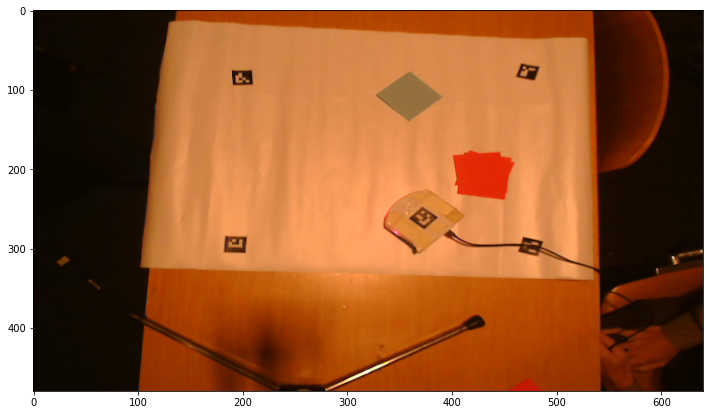

In [3]:
draw.plot_image(source.get_frame())

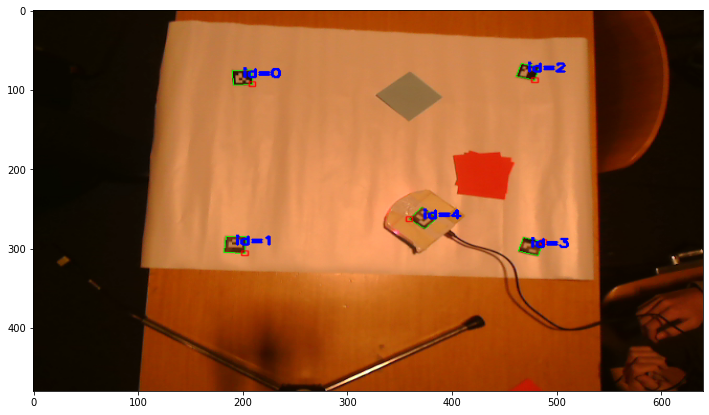

In [4]:
draw.display_aruco_markers(source, tools)

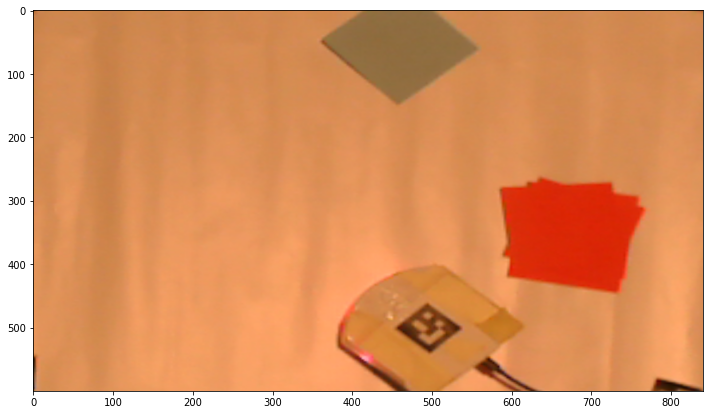

In [5]:
img = source.get_frame()
corners_by_id = tools.get_aruco_dict(img)
calibrated = tools.get_aruco_calibrated(img, corners_by_id)
draw.plot_image(calibrated)

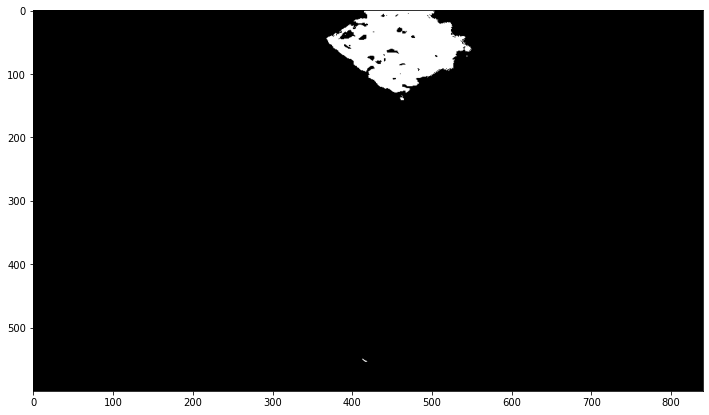

In [6]:
blue_bounds=vision.HSVBound(lb=np.array([17, 0, 0]), ub=np.array([180, 255, 200]))
mask = tools.get_color_mask(calibrated, blue_bounds)
draw.plot_image(mask)

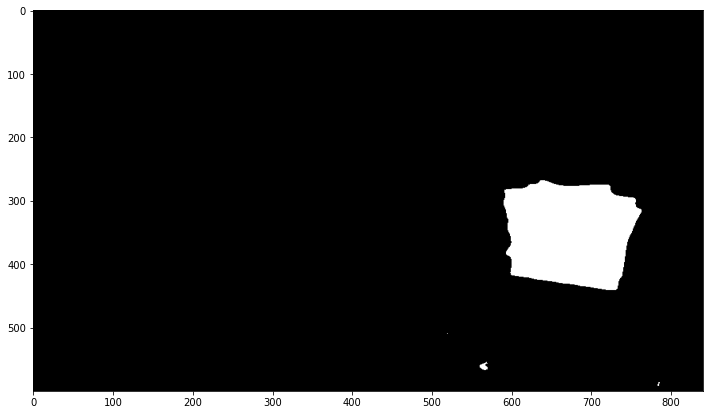

In [7]:
red_bounds=vision.HSVBound(lb=np.array([0, 230, 90]), ub=np.array([180, 255, 255]))
mask = tools.get_color_mask(calibrated, red_bounds)
draw.plot_image(mask)

In [8]:
pipeline = vision.VisionPipeline(source, tools=tools, red_bounds=red_bounds, blue_bounds=blue_bounds)

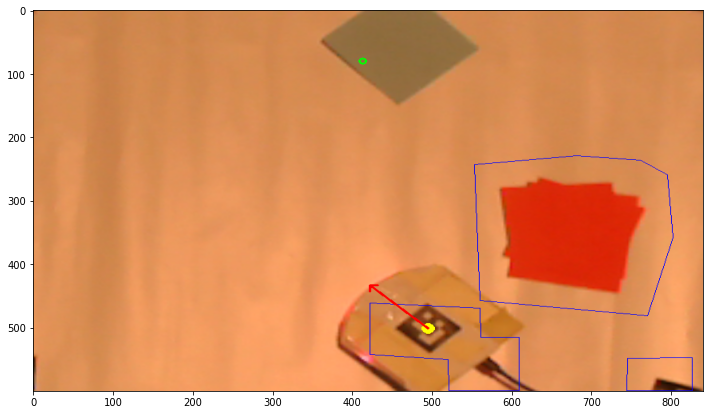

In [9]:
world = pipeline.analyze_scene()
result = pipeline.latest_frame.copy()
vision.draw_world(result, world)
draw.plot_image(result)

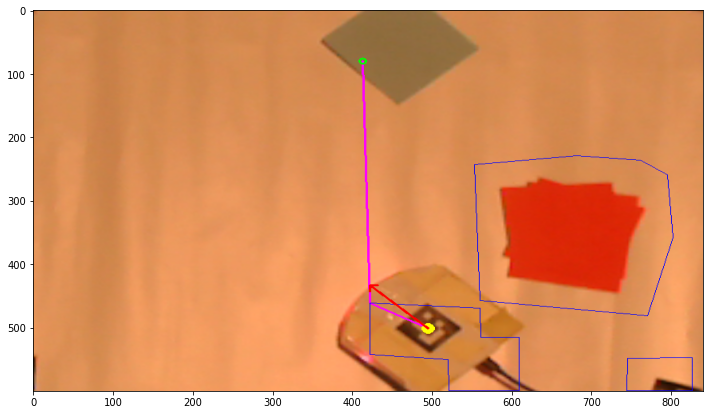

In [10]:
path = pathfinder.find_path(world)
result = pipeline.latest_frame.copy()
draw.draw_path(result, path)
vision.draw_world(result, world)
draw.plot_image(result)

In [11]:
th = thymio.Thymio()

In [12]:
while not world.robot_at_goal(50):
    world.robot = pipeline.get_robot_pose()
    command = navglobal.follow_path(world.robot, path)
    print(command)
    print(world.robot.position.distance(world.goal))
    th.process_command(command)
    result = pipeline.latest_frame.copy()
    # vision.draw_world(result, world)
    # draw.draw_path(result, path)
    # draw.plot_image(result)
    time.sleep(0.1)
th.stop()

MotorSpeed(left=array([100.21020118]), right=array([99.78979882]))
428.7970832562902
MotorSpeed(left=array([103.49191351]), right=array([96.50808649]))
407.8441324698882
MotorSpeed(left=array([113.4921424]), right=array([86.5078576]))
377.6173140256335
MotorSpeed(left=array([102.28199821]), right=array([97.71800179]))
348.55183496648965
MotorSpeed(left=array([108.67705643]), right=array([91.32294357]))
319.9920306701544
MotorSpeed(left=array([119.16181787]), right=array([80.83818213]))
293.69148142760685
MotorSpeed(left=array([128.41344029]), right=array([71.58655971]))
266.17492976660793
MotorSpeed(left=array([134.27250698]), right=array([65.72749302]))
236.26370299633973
MotorSpeed(left=array([138.909589]), right=array([61.090411]))
205.633731440343
MotorSpeed(left=array([140.68418028]), right=array([59.31581972]))
176.1230888620203
MotorSpeed(left=array([138.11762945]), right=array([61.88237055]))
142.23405911507
MotorSpeed(left=array([132.70531941]), right=array([67.29468059]))
108

In [13]:
th.stop()


## Final run sketch

The following sketches what the final run should look like combining every module together.

In [14]:
# world = vision.analyze_scene()
# path = pathfinder.find_path(world)
# sensor_data = thymio.read_sensor_data()

# while not world.robot_at_goal():
#     if navlocal.sees_obstacle(sensor_data):
#         command = navlocal.avoid_obstacle(sensor_data)
#     else:
#         command = navglobal.follow_path(world.robot, world.goal, path)
#     thymio.process_command(command)
#     sensors = thymio.read_sensor_data()
#     filtering.update_robot(world.robot, command, sensors)
#     time.sleep(0.1)

# print("Completed!")